Demo notebook for ptycho

Arthur McCray  
November 7, 2025

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np

import quantem as em
from quantem.core import config
from quantem.core.datastructures import Dataset4dstem
from quantem.diffractive_imaging import PtychographyDatasetRaster, PtychoLite, PtychoLiteDIP
from quantem.core.visualization import show_2d

config.set_device(1)
print(config.get("device"))

cuda:1


In [3]:
_f = Path("/data/shared/resources/example_data/ducky_251105_20mrad_500A-df_4A-step_5e+04-dose_clean.zip")
dset: Dataset4dstem = em.io.load(_f)
print(dset)

PROBE_ENERGY = 80e3 # eV
PROBE_SEMIANGLE = 20 # mrad
PROBE_DEFOCUS = 500 # A 

quantem Dataset named '4D-STEM dataset'
  shape: (37, 37, 200, 200)
  dtype: float32
  device: cpu
  origin: [0. 0. 0. 0.]
  sampling: [4.    4.    0.025 0.025]
  units: ['A', 'A', 'A^-1', 'A^-1']
  signal units: 'arb. units'


Calculated best fit rotation = 0 degrees.


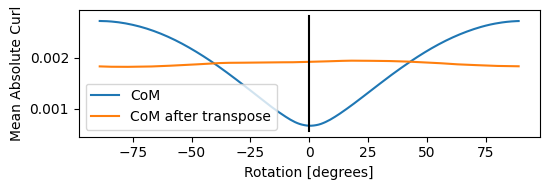

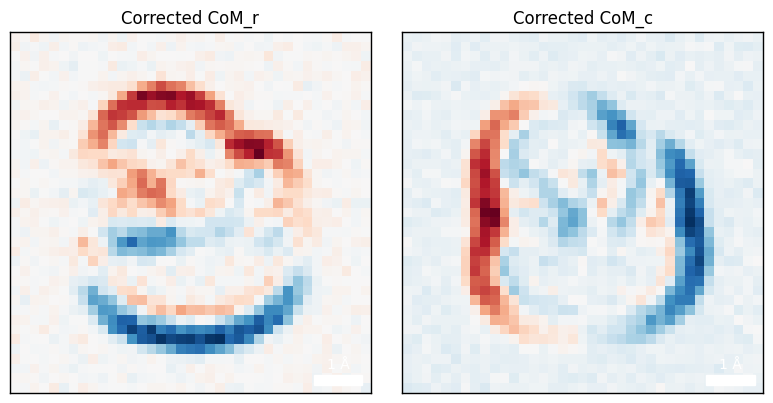

Normalizing intensities:   0%|          | 0/1369 [00:00<?, ?probe position/s]

In [4]:
pdset = PtychographyDatasetRaster.from_dataset4dstem(dset)

pdset.preprocess(
    com_fit_function="constant",
    plot_rotation=True,
    plot_com=True,
)

In [20]:
ptycho_pix = PtychoLite.from_dataset(
    dset=pdset,
    num_slices=1,
    num_probes=1,
    obj_type="pure_phase",
    energy=PROBE_ENERGY,
    defocus=PROBE_DEFOCUS,
    semiangle_cutoff=PROBE_SEMIANGLE,
    obj_padding_px=(32,32),
)

  0%|          | 0/100 [00:00<?, ?it/s]

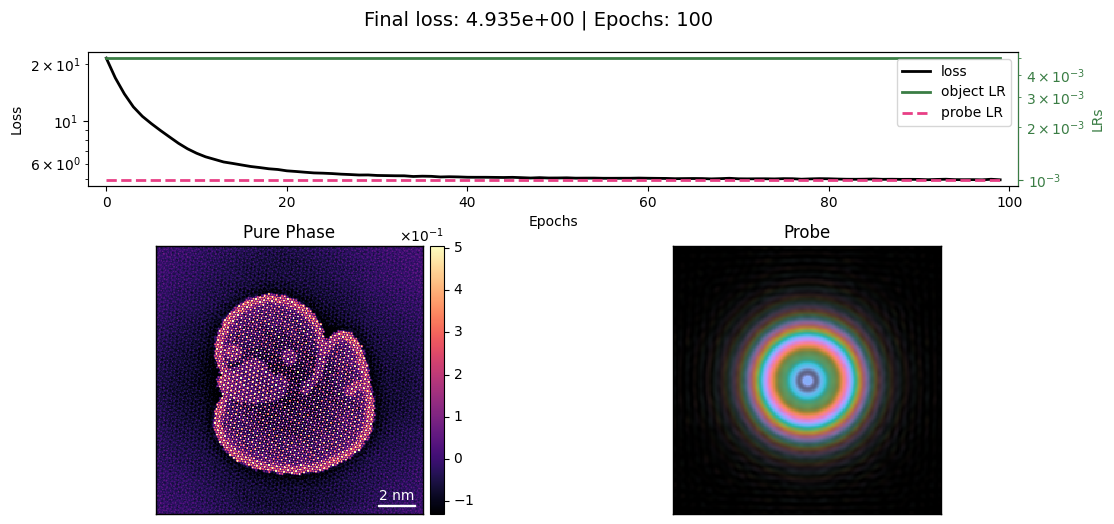

In [21]:
ptycho_pix.reconstruct(
    num_iter=100,
    device="gpu", # this will run on the GPU already set by config.set_device()
    # equivalent to device=config.get("device")
    # device=3 will run on GPU 3, even if its not the default device
    batch_size=128,
).visualize()

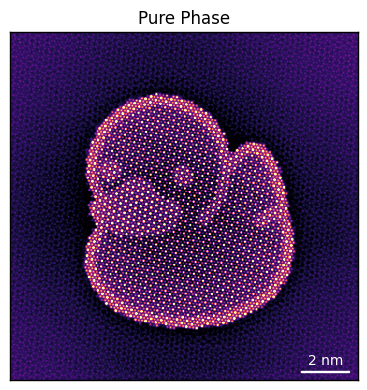

In [22]:
ptycho_pix.show_obj()

  0%|          | 0/10 [00:00<?, ?it/s]

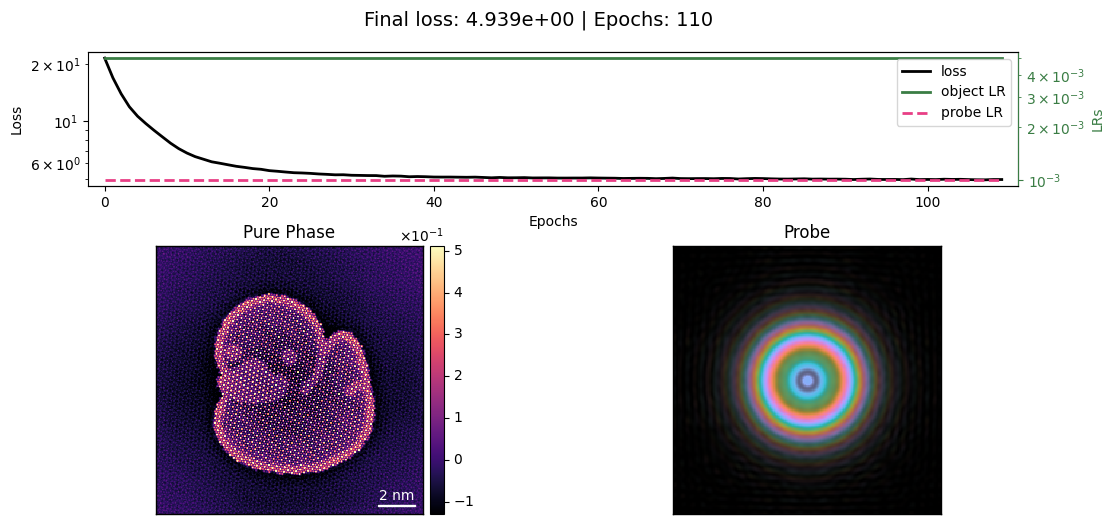

In [23]:
# default of reset=False, so will continue from previous reconstruction
ptycho_pix.reconstruct(10).visualize()

  0%|          | 0/10 [00:00<?, ?it/s]

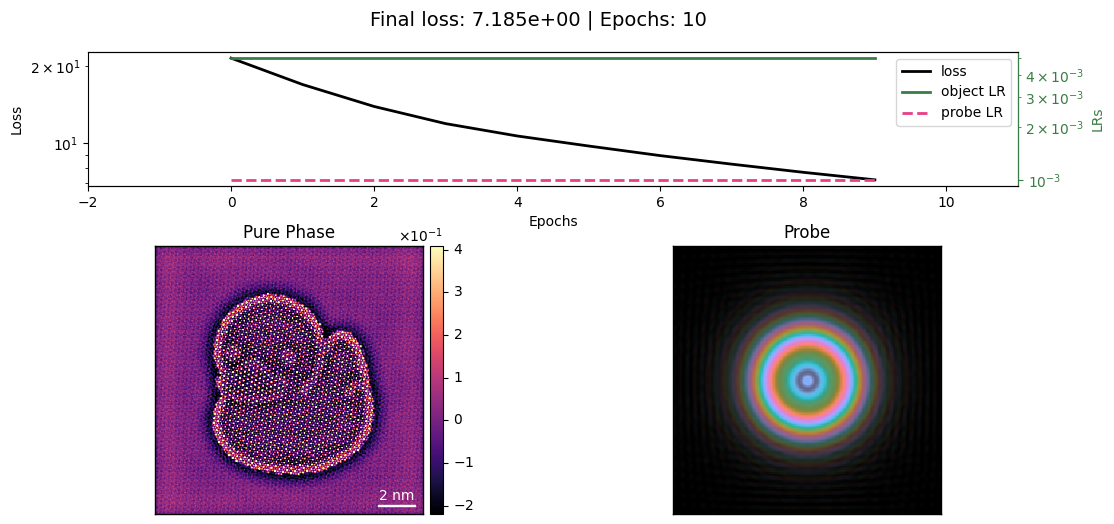

In [24]:
ptycho_pix.reconstruct(10, reset=True).visualize()

## DIP

  0%|          | 0/50 [00:00<?, ?it/s]

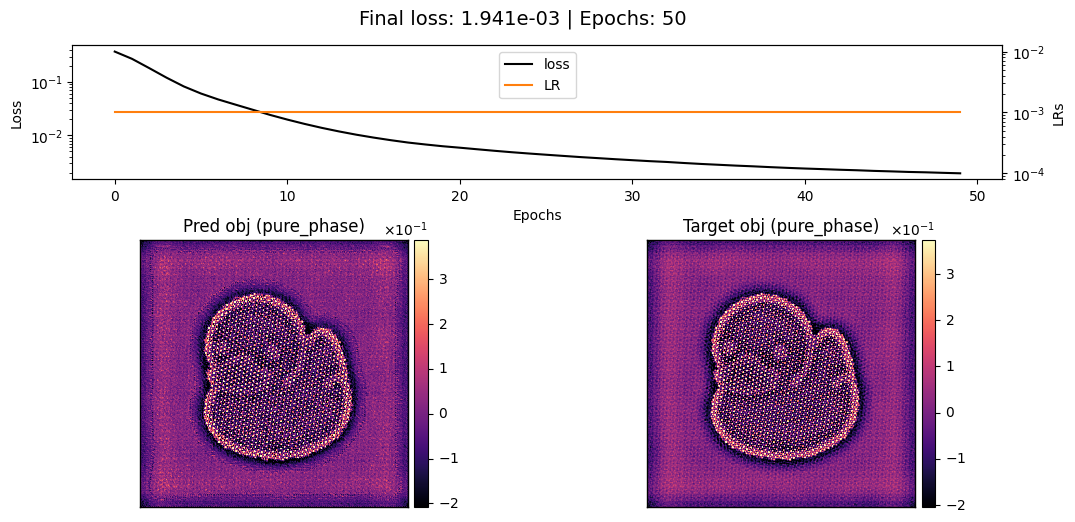

  0%|          | 0/50 [00:00<?, ?it/s]

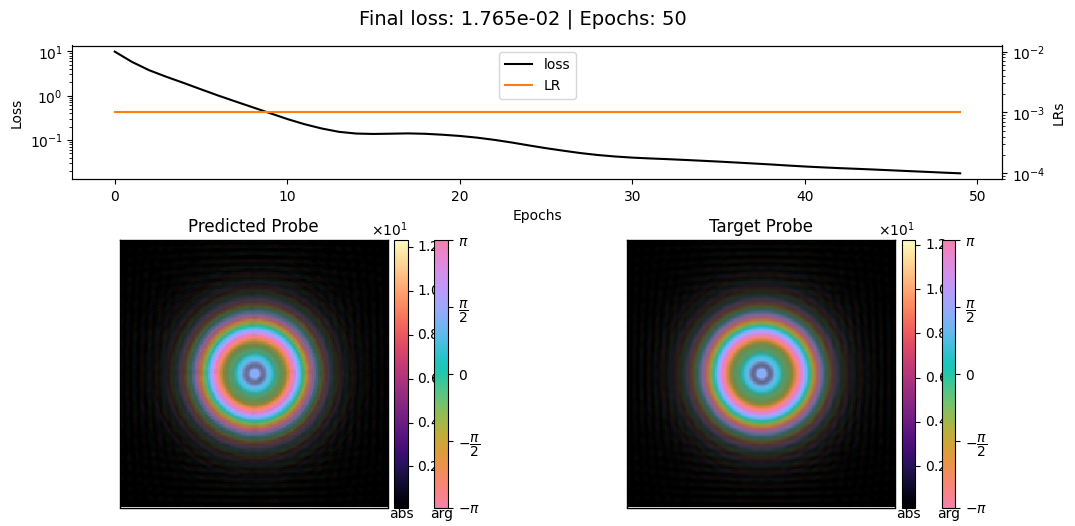

In [26]:
ptycho_dip = PtychoLiteDIP.from_ptycholite(
    ptycholite=ptycho_pix,
    pretrain_iters=50,
    device='gpu', 
)

  0%|          | 0/25 [00:00<?, ?it/s]

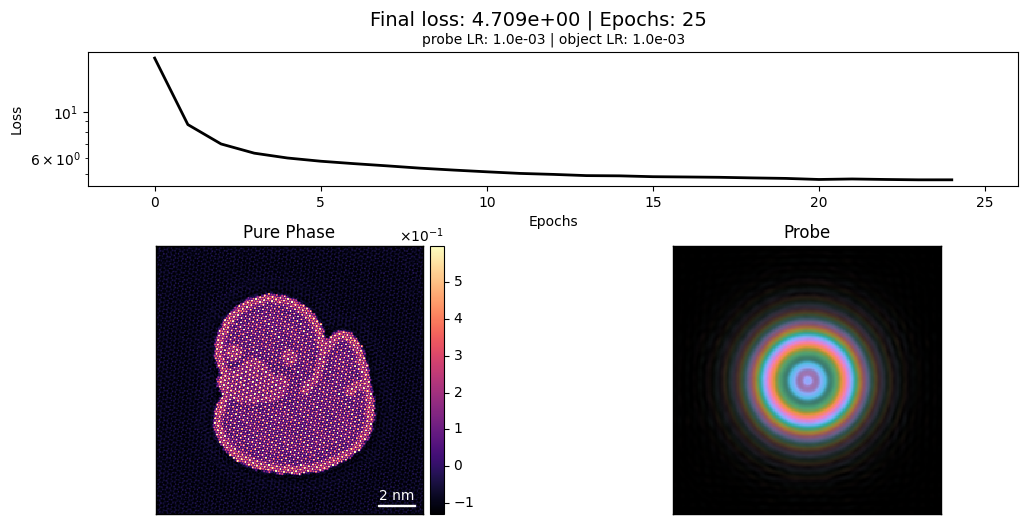

In [48]:
ptycho_dip.reconstruct(
    lr_probe=1e-3,
    lr_obj=1e-3,
    num_iter=25, 
    reset=True, 
    scheduler_type="plateau", # other scheduler types are `exp`, `cyclic`, `none` 
    batch_size=128,
).visualize()

  0%|          | 0/100 [00:00<?, ?it/s]

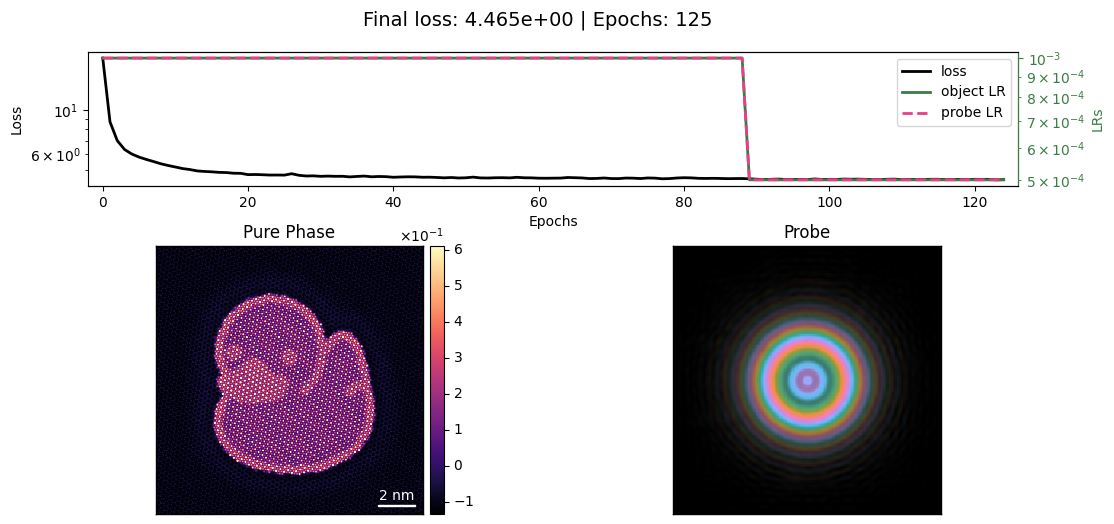

In [ ]:
ptycho_dip.reconstruct(100).visualize()

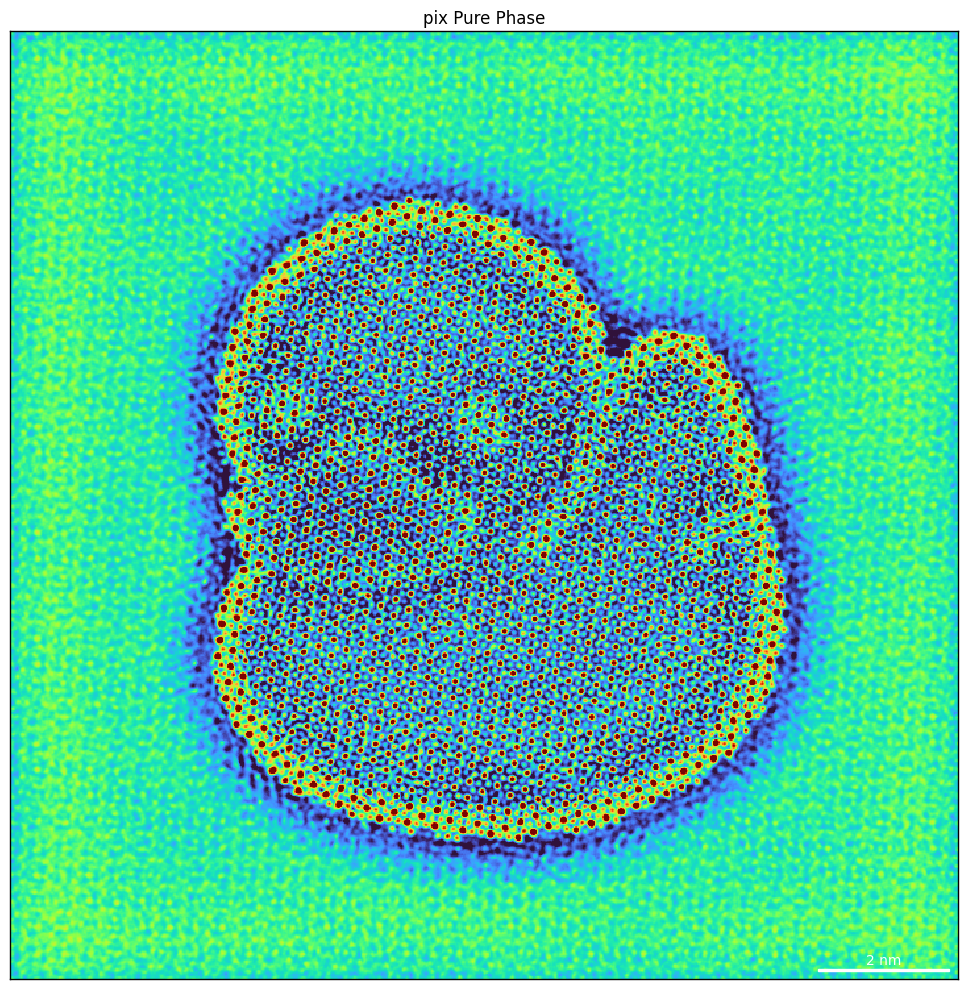

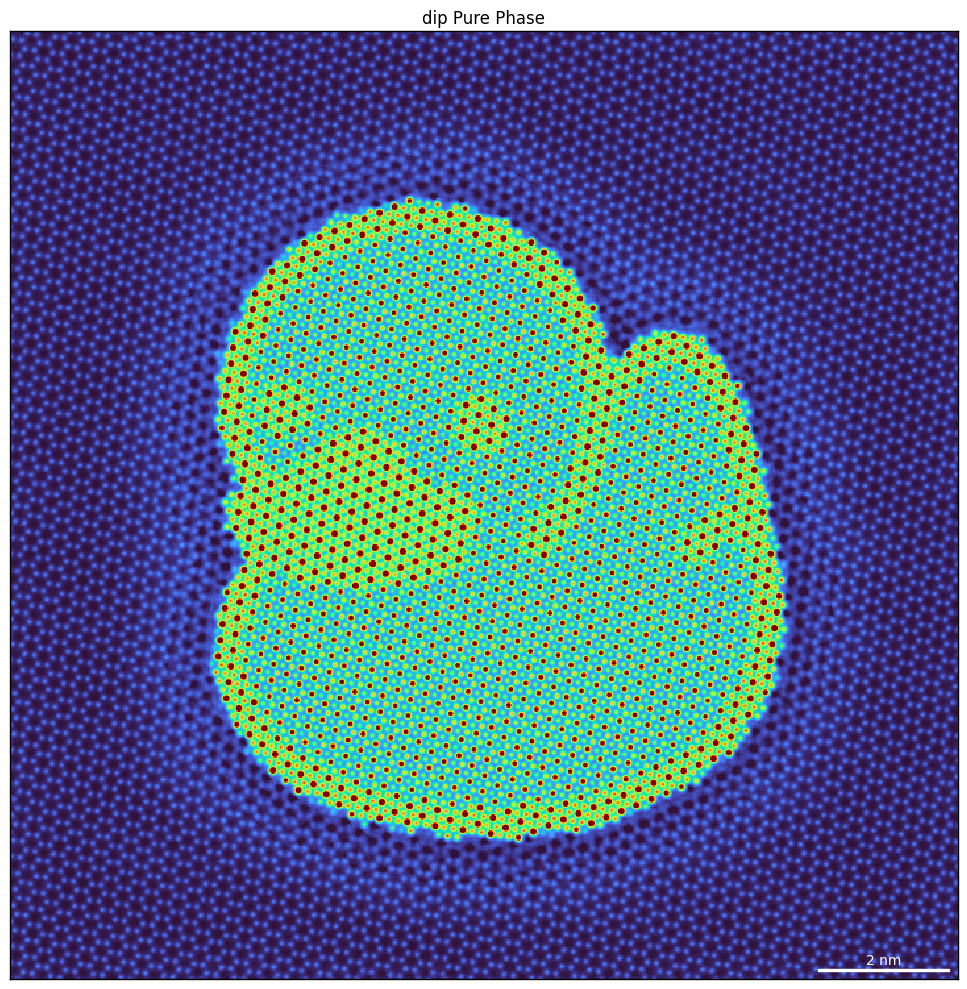

In [37]:
ptycho_pix.show_obj(axsize=(10,10), cmap='turbo', title='pix')
ptycho_dip.show_obj(axsize=(10,10), cmap='turbo', title='dip')

# Save/load
- can save and pick up where you left off 

In [13]:
ptycho_dip.save("../data/ptycholite_dip.zip", mode='o')

Saving ptychography object to ../data/ptycholite_dip.zip


In [14]:
ptycho_dip2 = PtychoLite.from_file("../data/ptycho_dip.zip")

Successfully reloaded dataset from /home/amccray/code/quantem-tutorials/data/ducky_clean.zip


Epoch 10/10, Loss: 1.461e+00: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


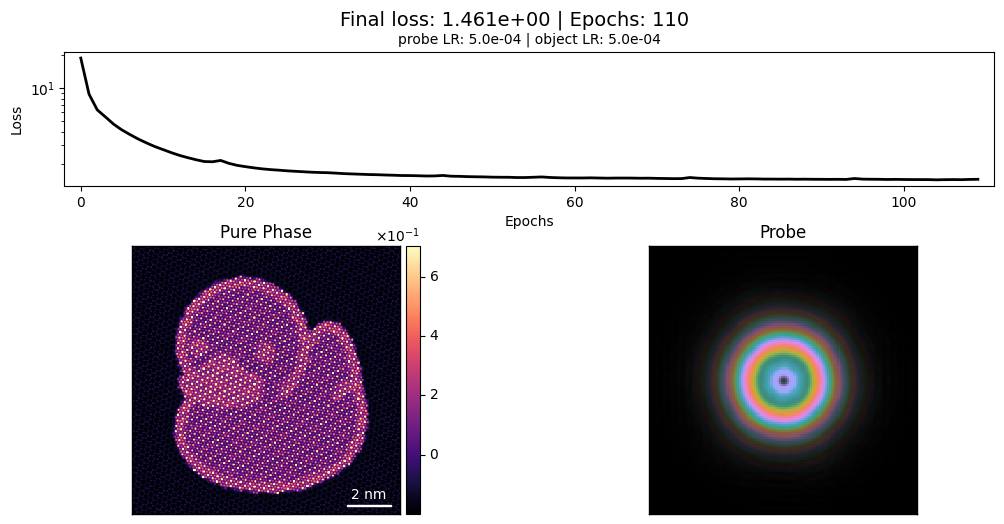

In [15]:
ptycho_dip2.reconstruct(
    num_iter=10,
    device='gpu',
).visualize()

obj type: <class 'numpy.ndarray'> | obj.shape: (1, 720, 720) | obj.dtype: complex64


(<Figure size 400x400 with 1 Axes>, <Axes: >)

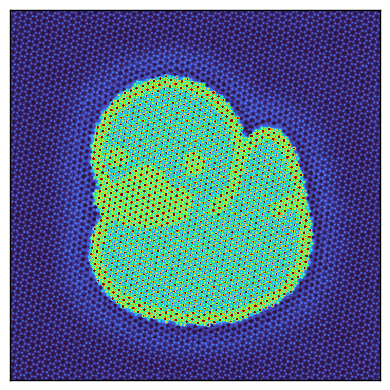

In [ ]:
obj = ptycho_dip.obj_cropped # shape (num_slices, rows, cols)
print(f"obj type: {type(obj)} | obj.shape: {obj.shape} | obj.dtype: {obj.dtype}")
show_2d(
    np.angle(obj).sum(0),
    cmap='turbo',
    
)
